# Timeseries

This notebook serves as a template for a bunch of timeseries tasks. In particular we will model:

- the weather
- oil prices

As you'll see in a bit ... timeseries models tend to vary quite a bit

In [1]:
import polars as pl

df = pl.read_csv("datasets/me-temperatures.csv")

In [2]:
df.head()

timestamp,y
str,f64
"""1981-01-01""",20.7
"""1981-01-02""",17.9
"""1981-01-03""",18.8
"""1981-01-04""",14.6
"""1981-01-05""",15.8


In [6]:
df.with_columns(timestamp=pl.col("timestamp").str.to_datetime()).plot("timestamp", "y")

:Curve   [timestamp]   (y)

In [8]:
def datetime_feats(dataf):
    return dataf.with_columns(
        day_of_year=pl.col("timestamp").str.to_datetime().dt.ordinal_day()
    ).drop("timestamp")

datetime_feats(df).head()

y,day_of_year
f64,i16
20.7,1
17.9,2
18.8,3
14.6,4
15.8,5


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, SplineTransformer

pipe = make_pipeline(
    FunctionTransformer(datetime_feats),
    SplineTransformer(n_knots=6, extrapolation="periodic")
)

In [26]:
X, y = df.drop("y"), df.select("y").to_numpy().reshape(-1)

In [27]:
pipe.fit_transform(X).shape

(3647, 5)

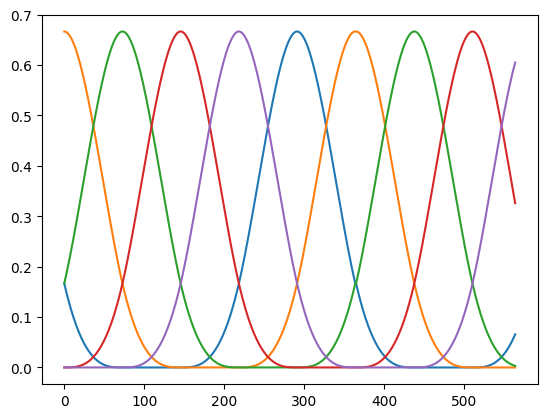

In [28]:
import matplotlib.pylab as plt

plt.plot(pipe.fit_transform(X.head(565)));

In [35]:
from sklearn.linear_model import Ridge

feat_pipe = make_pipeline(
    FunctionTransformer(datetime_feats),
    SplineTransformer(n_knots=6, extrapolation="periodic")
)

mod_pipe = make_pipeline(
    feat_pipe,
    Ridge()
)

mod_pipe.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function datetime_feats at 0x281bb4220>)),
                                 ('splinetransformer',
                                  SplineTransformer(extrapolation='periodic',
                                                    n_knots=6))])),
                ('ridge', Ridge())])

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

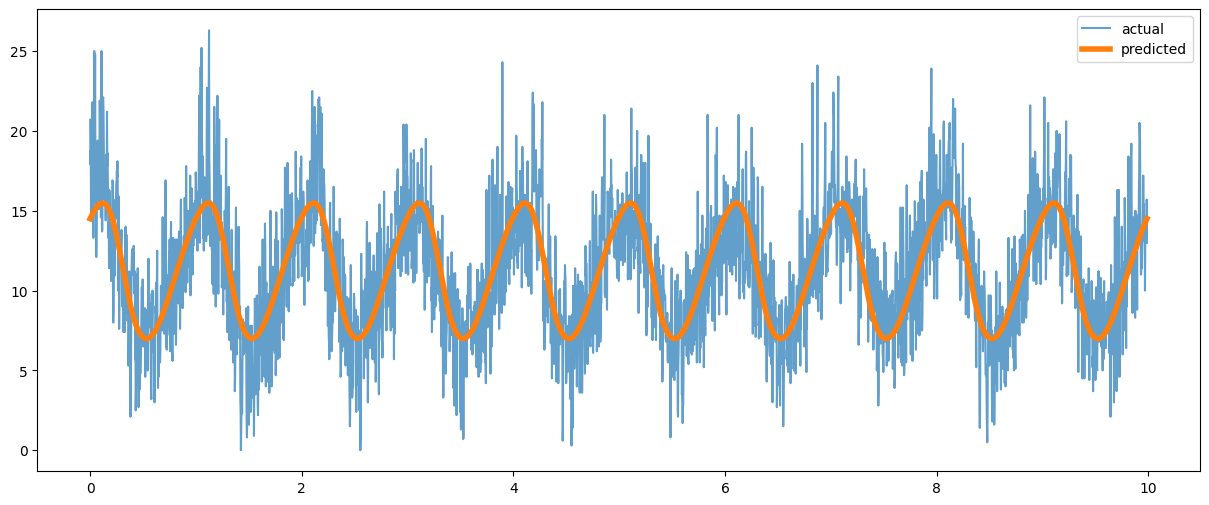

In [36]:
import numpy as np

plt.figure(figsize=(15, 6))
plt.plot(np.arange(y.shape[0]) / 365, y, label="actual", alpha=0.7)
plt.plot(np.arange(y.shape[0]) / 365, mod_pipe.predict(X), label="predicted", linewidth=4)
plt.legend();

In [37]:
from sklearn.linear_model import QuantileRegressor

feat_pipe = make_pipeline(
    FunctionTransformer(datetime_feats),
    SplineTransformer(n_knots=6, extrapolation="periodic")
)

mod_pipe_q_lower = make_pipeline(feat_pipe, QuantileRegressor(quantile=0.1, alpha=0.001))
mod_pipe_q_upper = make_pipeline(feat_pipe, QuantileRegressor(quantile=0.9, alpha=0.001))

mod_pipe_q_lower.fit(X, y)
mod_pipe_q_upper.fit(X, y);

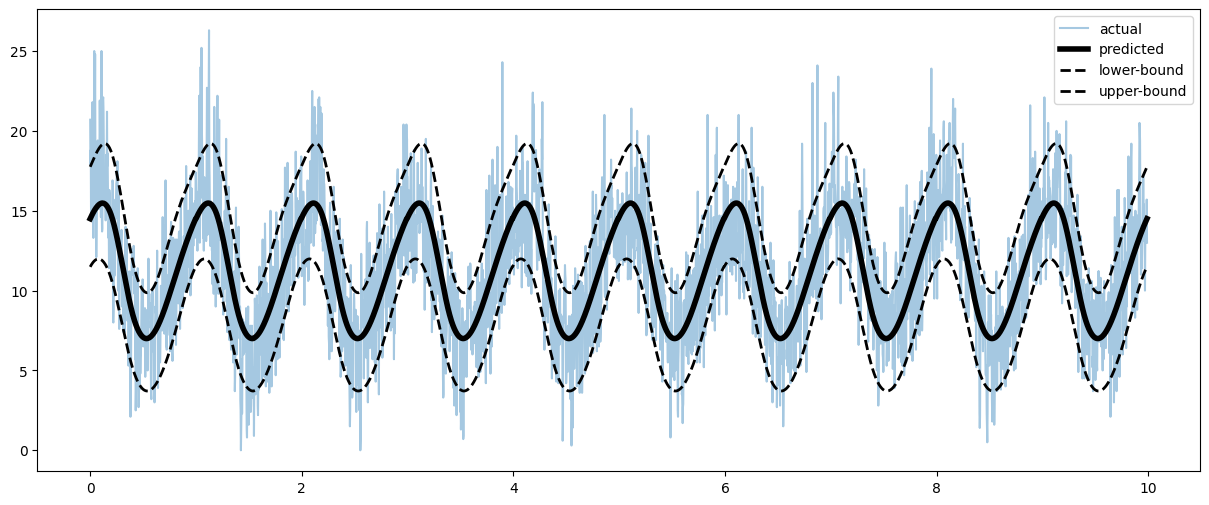

In [38]:
import numpy as np

plt.figure(figsize=(15, 6))
plt.plot(np.arange(y.shape[0]) / 365, y, label="actual", alpha=0.4)
plt.plot(np.arange(y.shape[0]) / 365, mod_pipe.predict(X), label="predicted", color="black", linewidth=4)
plt.plot(np.arange(y.shape[0]) / 365, mod_pipe_q_lower.predict(X), label="lower-bound", color="black", linestyle="--", linewidth=2)
plt.plot(np.arange(y.shape[0]) / 365, mod_pipe_q_upper.predict(X), label="upper-bound", color="black", linestyle="--", linewidth=2)
plt.legend();

So this is a nice result, but it is also relatively easy. It's just a seasonal pattern that we're capturing here and that seems to fit this particular dataset pretty well.

In [39]:
df = pl.read_csv("datasets/oil.csv").drop_nulls()

In [40]:
df.with_columns(date=pl.col("date").str.to_datetime()).plot("date")

:Curve   [date]   (dcoilwtico)

This is a whole lot trickyier to predict! 

But you may also wonder the predictive expectations are different. In the case of seasonal temperature prediction you could argue that it's reasonable to "predict a year ahead". But the prediction is much more short term here.

So what might be reasonable?

In [56]:
df_feat = (
    df
    .with_columns(**{f"lag{i}": pl.col("dcoilwtico").shift(i) for i in range(7, 14)})
    .drop_nulls()
)

In [58]:
df_feat.head(4)

date,dcoilwtico,lag7,lag8,lag9,lag10,lag11,lag12,lag13
str,f64,f64,f64,f64,f64,f64,f64,f64
"""2013-01-22""",96.09,93.81,93.08,93.21,93.2,93.12,92.97,93.14
"""2013-01-23""",95.06,93.6,93.81,93.08,93.21,93.2,93.12,92.97
"""2013-01-24""",95.35,94.27,93.6,93.81,93.08,93.21,93.2,93.12
"""2013-01-25""",95.15,93.26,94.27,93.6,93.81,93.08,93.21,93.2


Note, we're kind of hitting a scikit-learn anti-pattern here. We're using `y` to generate `X`!

In [59]:
X, y = df_feat.drop("date", "dcoilwtico"), df_feat.select("dcoilwtico").to_numpy().reshape(-1)

In [60]:
from sklearn.linear_model import QuantileRegressor

mod = QuantileRegressor(quantile=0.5, alpha=0.001)
mod_lower = QuantileRegressor(quantile=0.05, alpha=0.001)
mod_upper = QuantileRegressor(quantile=0.95, alpha=0.001)

for m in [mod, mod_lower, mod_upper]:
    m.fit(X, y)

In [61]:
df_feat.head()

date,dcoilwtico,lag7,lag8,lag9,lag10,lag11,lag12,lag13
str,f64,f64,f64,f64,f64,f64,f64,f64
"""2013-01-22""",96.09,93.81,93.08,93.21,93.2,93.12,92.97,93.14
"""2013-01-23""",95.06,93.6,93.81,93.08,93.21,93.2,93.12,92.97
"""2013-01-24""",95.35,94.27,93.6,93.81,93.08,93.21,93.2,93.12
"""2013-01-25""",95.15,93.26,94.27,93.6,93.81,93.08,93.21,93.2
"""2013-01-28""",95.95,94.28,93.26,94.27,93.6,93.81,93.08,93.21


In [62]:
pltr = pl.DataFrame({
    "x": np.arange(y.shape[0]),
    "y": df_feat['dcoilwtico'],
    "pred": mod.predict(X),
    "pred_lower": mod_lower.predict(X),
    "pred_upper": mod_upper.predict(X)
})

In [63]:
import altair as alt

charts = []

p1 = (
    alt.Chart(pltr)
      .mark_line()
      .encode(x='x', y='y')
)

p2 = (
    alt.Chart(pltr)
      .mark_line(color="orange")
      .encode(x='x', y='pred')
)

p3 = (
    alt.Chart(pltr)
      .mark_line(color="orange", opacity=0.4)
      .encode(x='x', y='pred_lower')
)

p4 = (
    alt.Chart(pltr)
      .mark_line(color='orange', opacity=0.4)
      .encode(x='x', y='pred_upper')
)

(p1 + p3 + p4).properties(width=1000).interactive()

alt.LayerChart(...)

This looks "ok", but remember that this is really just like picking a rolling average. It looks good because the task is relatively easy: we just predict the mean of the last few days. Also ... the errors are not evenly distributed ...

Consider this bottom chart ... it is the cumsum of the errors.

In [64]:
pltr2 = pltr.with_columns(diff=pl.col("pred") - pl.col("y")).with_columns(cs=pl.col('diff').cum_sum())

d = alt.Chart(pltr2).mark_line().encode(x='x', y='cs')

((p1 + p3 + p4).properties(width=1000) & d.properties(width=1000)).interactive()

alt.VConcatChart(...)

# What about sales data?

This is where it can get very tricky ... best to whiteboard and then give a preview of a hobby project.

In [21]:
from playtime.formula import seasonal, feats, dummy, time 

formula = seasonal("day_of_year") + feats("day_of_week") + seasonal("day_of_year") * feats("day_of_week")

In [22]:
formula.pipeline

FeatureUnion(transformer_list=[('pipeline',
                                Pipeline(steps=[('selectcols',
                                                 SelectCols(cols=['day_of_year'])),
                                                ('splinetransformer',
                                                 SplineTransformer(extrapolation='periodic'))])),
                               ('selectcols', SelectCols(cols=['day_of_week'])),
                               ('unionpolynomialfeaturizer',
                                UnionPolynomialFeaturizer(union_estimator=FeatureUnion(transformer_list=[('pipeline',
                                                                                                          Pipeline(steps=[('selectcols',
                                                                                                                           SelectCols(cols=['day_of_year'])),
                                                                                                                          ('splinetransformer',
                                                                                                                           SplineTransformer(extrapolation='periodic'))])),
                                                                                                         ('selectcols',
                                                                                                          SelectCols(cols=['day_of_week']))])))])